This colab implements the Pix2Pix GAN. 

In [ ]:
# generated images and metrics will be saved on your Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import time

Load images

In [ ]:
imgs_path = glob.glob('/content/gdrive/My Drive/train/*.jpg')

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/127.5 - 1
    input_mask = tf.cast(input_mask, tf.float32)/127.5 - 1
    return input_image, input_mask

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def flip_left_right(input_image, real_image):
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [ ]:
def load_image(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]
    input_image = tf.image.resize(input_image, (256, 256))
    input_mask = tf.image.resize(input_mask, (256, 256))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask) 

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

Prepare training dataset

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(imgs_path)

In [ ]:
train = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
trainRandomCrop = train.map(random_crop, num_parallel_calls=tf.data.experimental.AUTOTUNE)
trainFlipLeftRight = train.map(flip_left_right, num_parallel_calls=tf.data.experimental.AUTOTUNE)
print(train)
print(trainRandomCrop)
print(trainFlipLeftRight)
train = train.concatenate(trainRandomCrop).concatenate(trainFlipLeftRight)

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>


In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 200

In [ ]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(train_dataset)

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>


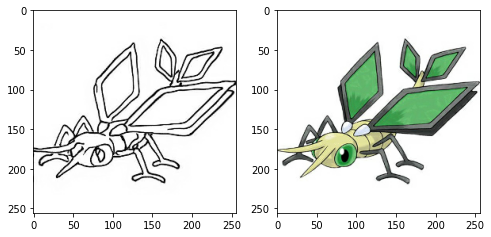

In [ ]:
plt.figure(figsize=(8, 5))
for img, musk in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

Prepare testing dataset

In [ ]:
imgs_path_test = glob.glob('/content/gdrive/My Drive/test/*.jpg')

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices(imgs_path_test)

In [ ]:
def load_image_test(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]
    input_image = tf.image.resize(input_image, (256, 256))
    input_mask = tf.image.resize(input_mask, (256, 256))
    
    input_image, input_mask = normalize(input_image, input_mask)
    print(input_image.shape)
    return input_image, input_mask

In [ ]:
dataset_test = dataset_test.map(load_image_test)
print(dataset_test)

(256, 256, 3)
<MapDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>


In [ ]:
dataset_test = dataset_test.batch(BATCH_SIZE)

(20, 256, 256, 3)


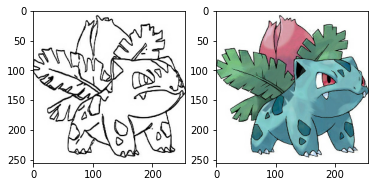

In [ ]:
for img, musk in dataset_test.take(1):
    plt.subplot(1,2,1)
    print(img.shape)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

Generate building blocks needed for Pix2Pix

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

#    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Visualise unet generator

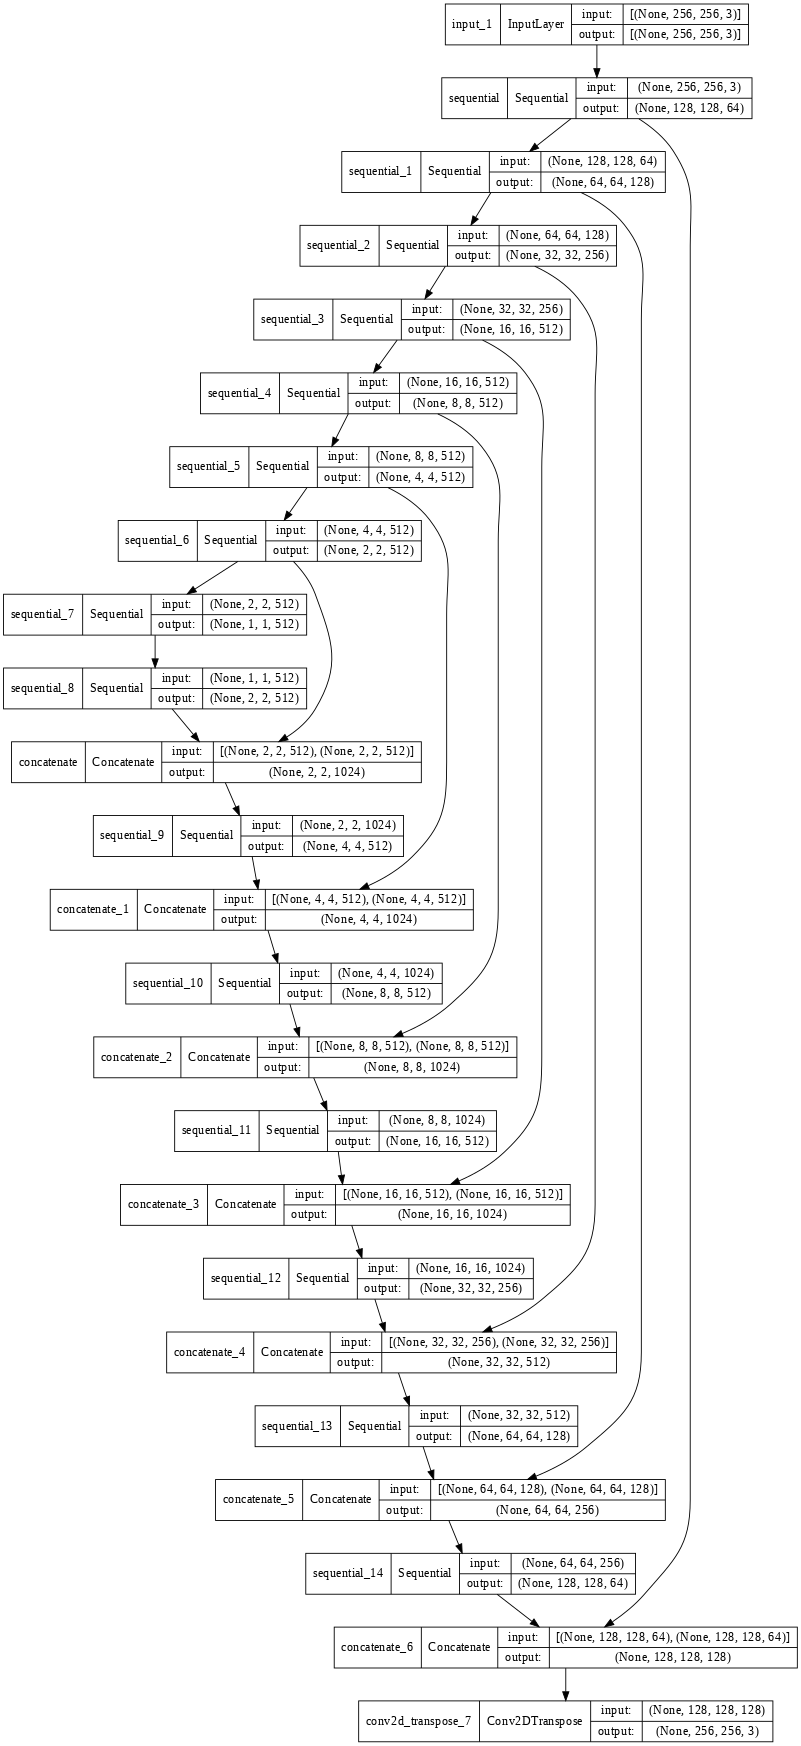

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  padding='same',
                                  use_bias=False)(down3) # (bs, 32, 32, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(leaky_relu) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

(20, 256, 256, 3)
(20, 256, 256, 3)


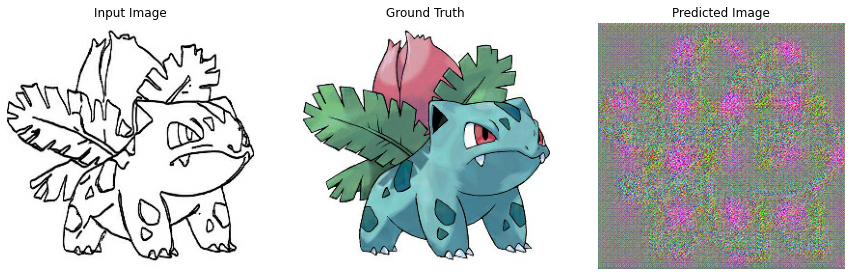

In [ ]:
for example_input, example_target in dataset_test.take(1):
    print(example_input.shape)
    print(example_target.shape)
    generate_images(generator, example_input, example_target)


Set up training

In [ ]:
EPOCHS = 100

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
    print(input_image.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    return gen_total_loss, disc_loss, gen_gan_loss, gen_l1_loss

In [ ]:
epoch_loss_avg_gen = tf.keras.metrics.Mean('g_loss')
epoch_loss_avg_disc = tf.keras.metrics.Mean('d_loss')

In [ ]:
g_loss_results = []
d_loss_results = []

In [ ]:
import datetime

log_dir = '/content/gdrive/My Drive/logs/'
datetime_string = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime_string)

def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs+1):
        if epoch%10 == 0:
            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)
        
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            gen_total_loss, disc_loss, gen_gan_loss, gen_l1_loss = train_step(input_image, target, epoch)
            epoch_loss_avg_gen(gen_gan_loss)
            epoch_loss_avg_disc(disc_loss)

        # write to logs
        with summary_writer.as_default():
          tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
          tf.summary.scalar('disc_loss', disc_loss, step=epoch)
          tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
          tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)

        g_loss_results.append(epoch_loss_avg_gen.result())
        d_loss_results.append(epoch_loss_avg_disc.result())
        
        epoch_loss_avg_gen.reset_states()
        epoch_loss_avg_disc.reset_states()

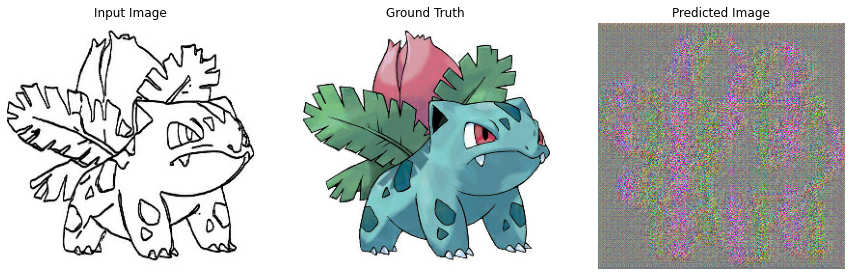

Epoch:  0
.(32, 256, 256, 3)
(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  1
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  2
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  3
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  4
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  5
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  6
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  7
.(32, 256, 256, 3)
.............................................................................(

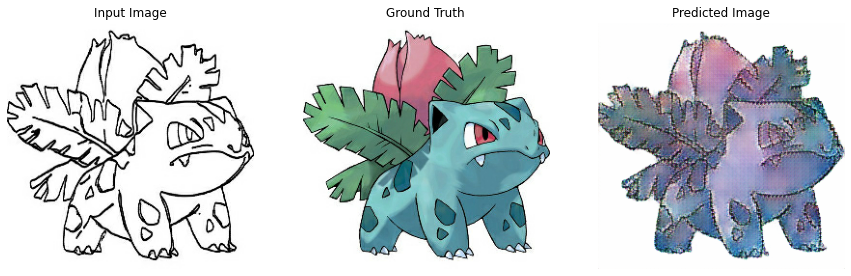

Epoch:  10
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  11
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  12
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  13
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  14
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  15
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  16
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  17
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

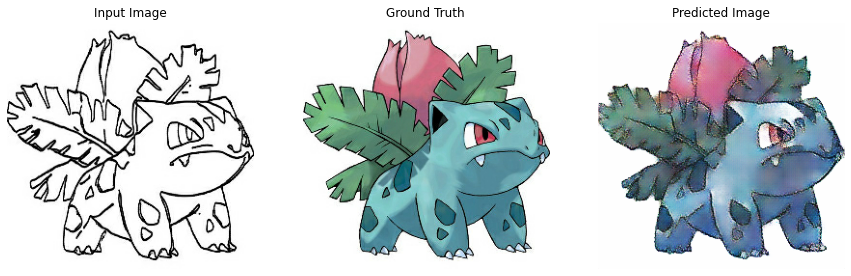

Epoch:  20
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  21
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  22
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  23
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  24
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  25
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  26
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  27
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

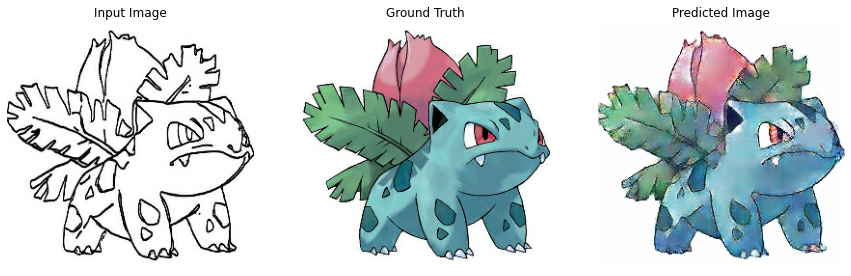

Epoch:  30
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  31
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  32
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  33
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  34
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  35
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  36
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  37
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

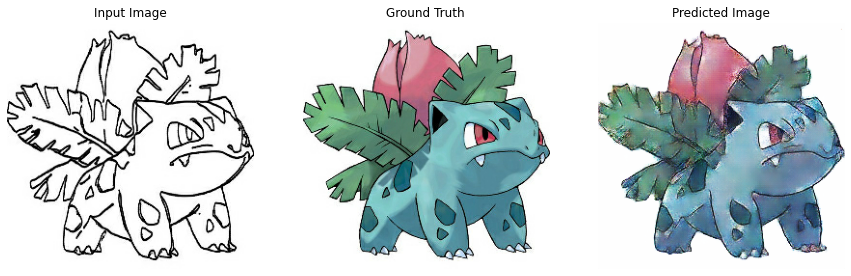

Epoch:  40
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  41
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  42
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  43
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  44
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  45
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  46
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  47
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

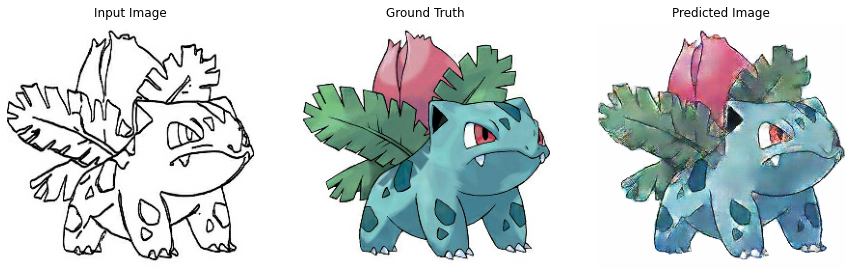

Epoch:  50
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  51
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  52
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  53
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  54
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  55
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  56
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  57
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

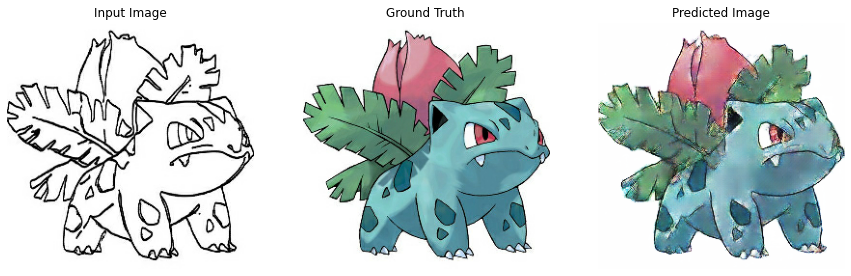

Epoch:  60
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  61
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  62
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  63
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  64
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  65
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  66
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  67
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

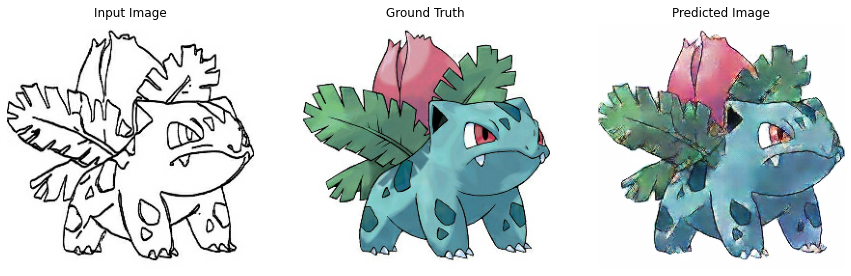

Epoch:  70
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  71
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  72
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  73
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  74
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  75
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  76
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  77
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

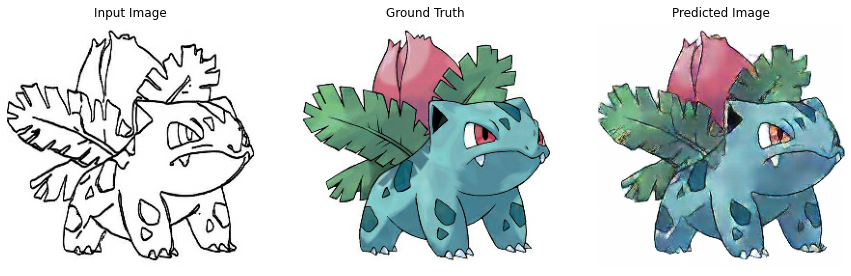

Epoch:  80
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  81
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  82
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  83
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  84
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  85
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  86
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  87
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

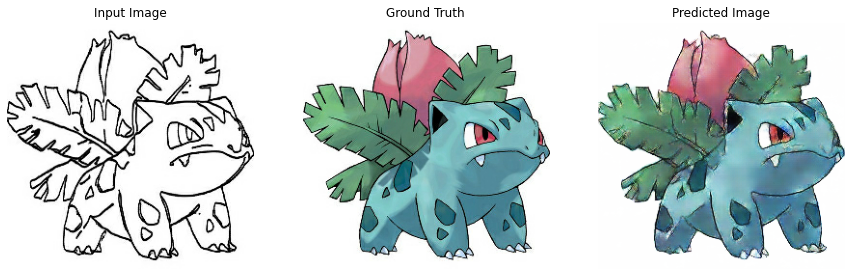

Epoch:  90
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  91
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  92
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  93
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  94
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  95
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  96
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)

Epoch:  97
.(32, 256, 256, 3)
.............................................................................(23, 256, 2

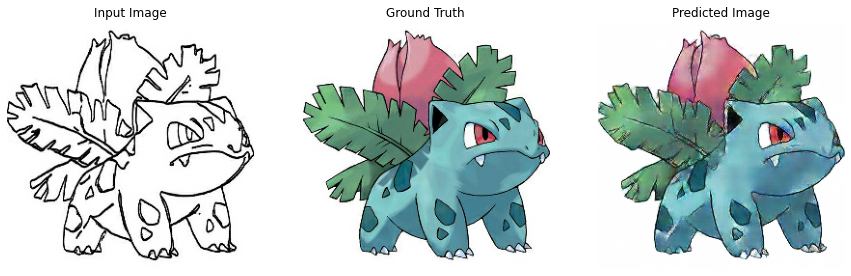

Epoch:  100
.(32, 256, 256, 3)
.............................................................................(23, 256, 256, 3)



In [ ]:
fit(train_dataset, EPOCHS, dataset_test)

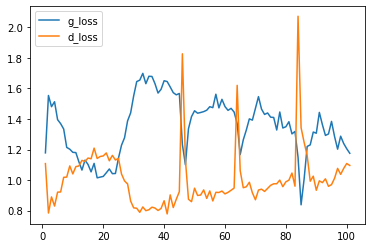

In [ ]:
plt.plot(range(1, len(g_loss_results)+1), g_loss_results, label='g_loss')
plt.plot(range(1, len(d_loss_results)+1), d_loss_results, label='d_loss')
plt.legend()

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 2.4 MB/s 


In [ ]:
tfjs_target_dir = '/content/gdrive/My Drive/trainedModels'
h5_target_dir = '/content/gdrive/My Drive/h5trainedModels/model.h5'

In [ ]:
generator.save(h5_target_dir, save_format='h5')

(20, 256, 256, 3)
(20, 256, 256, 3)


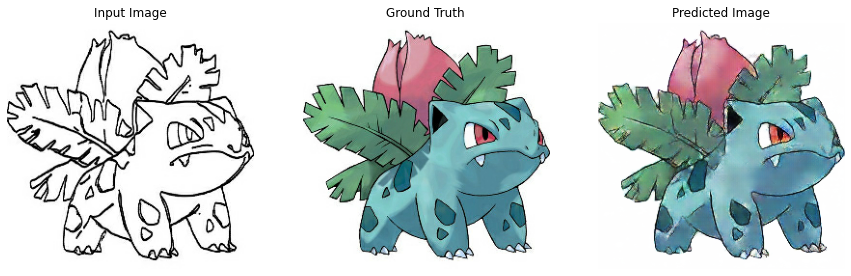

In [ ]:
from tensorflow import keras
model = keras.models.load_model(h5_target_dir)
for example_input, example_target in dataset_test.take(1):
    print(example_input.shape)
    print(example_target.shape)
    generate_images(model, example_input, example_target)

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(generator, tfjs_target_dir)